In [9]:
import ic_sets, auction_data
hist_plot = auction_data.hist_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline


In [15]:
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')
ic_solver = ic_sets.ICSets(rho_p=.001, rho_m=.001, auction_data=tsuchiura_data, k=.1, t=.05, m=.5)

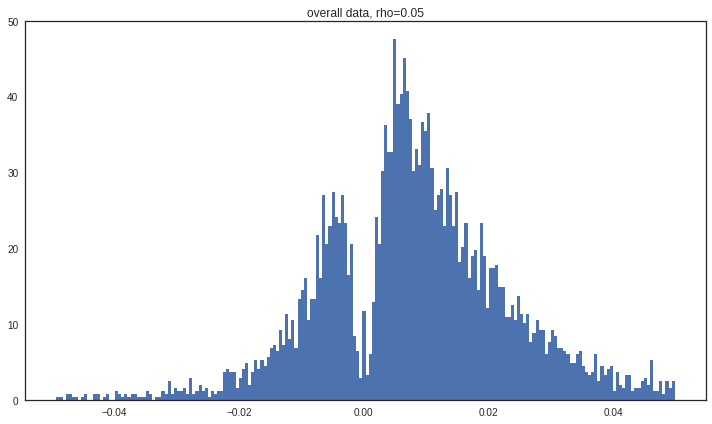

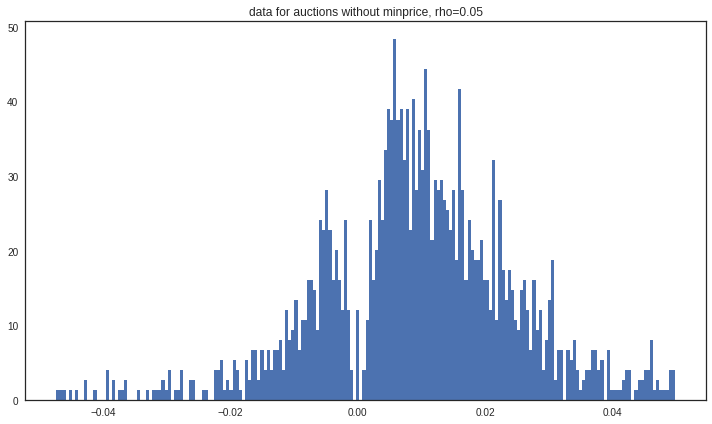

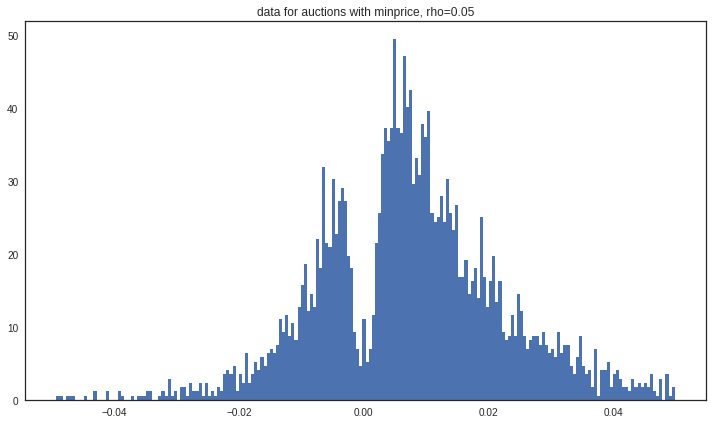

In [17]:
delta = tsuchiura_data.df_bids.norm_bid - tsuchiura_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta,'overall data, rho={}'.format(rho))
hist_plot(delta[tsuchiura_data.df_bids.minprice.isnull()], 
          'data for auctions without minprice, rho={}'.format(rho))
hist_plot(delta[~tsuchiura_data.df_bids.minprice.isnull()], 
          'data for auctions with minprice, rho={}'.format(rho))

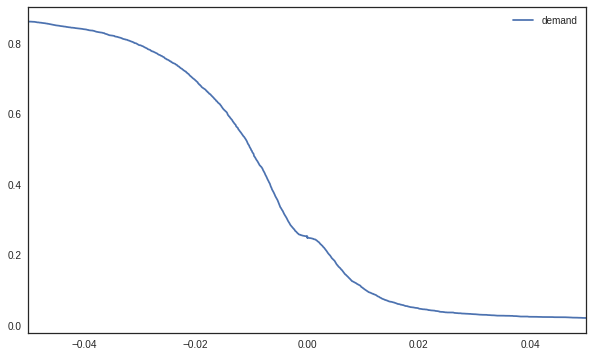

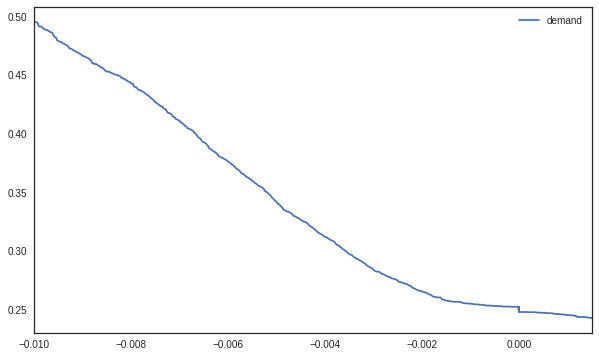

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7d2e6c5b90>, None)

In [4]:
tsuchiura_data.counterfactual_demand(.05,.05).plot(figsize = (10,6)), plt.show()
tsuchiura_data.counterfactual_demand(.0015,.01).plot(figsize = (10,6)), plt.show()

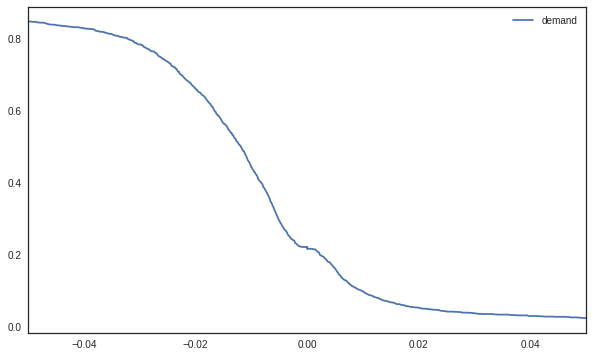

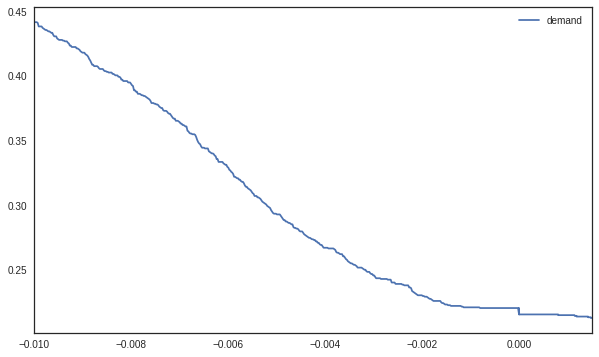

In [5]:
tsuchiura_data.set_bid_data(tsuchiura_data.df_bids[tsuchiura_data.df_bids.minprice.isnull()])
tsuchiura_data.counterfactual_demand(.05,.05).plot(figsize = (10,6)), plt.show()
tsuchiura_data.counterfactual_demand(.0015,.01).plot(figsize = (10,6))